In [2]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

In [3]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=4, worker_memory=8, master_memory=8)

spark.sql.shuffle.partitions,64
spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.port,40215
spark.sql.warehouse.dir,file:/users/home/mda205/DATA420%20Assignment%202/spark-warehouse
spark.master,spark://masternode2:7077
spark.cores.max,16
spark.executor.id,driver
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.executor.cores,4
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/mda205/spark/


In [4]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.recommendation import ALS

import json
import numpy as np

from pretty import SparkPretty  # download pretty.py from LEARN and put it in your M:\ or home directory
pretty = SparkPretty(limit=5)

import pandas as pd

import matplotlib.pyplot as plt
# %matplotlib notebook

from pyspark_dist_explore import hist
from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

import seaborn as sns

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.functions import col # i cant explain why i am cranky about col but i am

In [5]:
def savefile(filename, tablename):

    name = "mda205"

    data_path = f"hdfs:///user/{name}/outputs/{filename}/"


    tablename.write.mode("overwrite").csv(data_path)
    
    (tablename.write
        .option("compression", "gzip")
        .mode("overwrite")
        .csv(data_path))

In [6]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')
    
    
# Other imports to be used locally

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

# %matplotlib notebook

np.set_printoptions(edgeitems=5, threshold=100, precision=4)


def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    return x + np.array([-d, d])


# Helper functions

def evaluate_metrics_and_cost_local(pred_local, threshold, FP_cost, FN_cost, labelCol="label", predictionCol="customPrediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    pred_local[predictionCol] = (pred_local[probabilityCol].apply(lambda x: x[1]) > threshold).astype(int)

    total = pred_local.shape[0]

    nP_actual = (pred_local[labelCol] == 1).sum()
    nN_actual = (pred_local[labelCol] == 0).sum()

    nP = ((pred_local[predictionCol] == 1)).sum()
    nN = ((pred_local[predictionCol] == 0)).sum()
    TP = ((pred_local[predictionCol] == 1) & (pred_local[labelCol] == 1)).sum()
    FP = ((pred_local[predictionCol] == 1) & (pred_local[labelCol] == 0)).sum()
    FN = ((pred_local[predictionCol] == 0) & (pred_local[labelCol] == 1)).sum()
    TN = ((pred_local[predictionCol] == 0) & (pred_local[labelCol] == 0)).sum()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    cost_total = FP_cost * FP + FN_cost * FN

    return precision, recall, accuracy, cost_total

In [7]:
# Dataset names and attribute type mapping

attributes_path = 'hdfs:///data/msd/audio/attributes/'

hadoop = sc._jvm.org.apache.hadoop
fs = hadoop.fs.FileSystem
conf = hadoop.conf.Configuration()
path = hadoop.fs.Path(attributes_path)
getfile=fs.get(conf).listStatus(path)

datasets=[]
modified_filenames=[]

for f in getfile:
    
    filename = f.getPath().getName()
    datasets.append(filename[:-15])
    
    mod_filename = filename.replace("-","_")
    modified_filenames.append(mod_filename[:-17])
    

lookup = {
    'real': DoubleType(),
    'NUMERIC': DoubleType(),
    'float': DoubleType(),
    'string': StringType(),
    'STRING': StringType(),
}


# Choose a dataset name, load attribute names, and define schemas based on attribute names

def SingleDataset(dataname):

    name = f'{dataname}'

    metadata_schema = StructType([
        StructField("name", StringType()),
        StructField("type", StringType())])

    metadata = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv', schema=metadata_schema)

    schema_actual = StructType([
        StructField(name, lookup[typename], True) for name, typename in metadata.collect()])

    SingleData = spark.read.csv(f'/data/msd/audio/features/{name}.csv', 
                                schema=schema_actual, quote="'").withColumnRenamed(schema_actual[-1].name, "track_id")
    
    def DFCounts(name, df):
        print(name+" has:")
        print(f"{len(df.columns)} columns")
        print(f"{df.count()} rows")
        df=df.select((F.countDistinct("track_id")).alias("total unique songs"))
        df.show()
    
    counts = lambda : DFCounts(name, SingleData)
    
    return SingleData, counts

In [8]:
# !hdfs dfs -ls -h hdfs:///data/msd/tasteprofile

In [9]:
mismatches_schema = StructType([
    StructField("song_id", StringType(), True),
    StructField("song_artist", StringType(), True),
    StructField("song_title", StringType(), True),
    StructField("track_id", StringType(), True),
    StructField("track_artist", StringType(), True),
    StructField("track_title", StringType(), True)
])

path = "/scratch-network/courses/2023/DATA420-23S1/data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt"
with open(path, "r") as f:
    lines = f.readlines()
    sid_matches_manually_accepted = []
    for line in lines:
        if line.startswith("< ERROR: "):
            a = line[10:28]
            b = line[29:47]
            c, d = line[49:-1].split("  !=  ")
            e, f = c.split("  -  ")
            g, h = d.split("  -  ")
            sid_matches_manually_accepted.append((a, e, f, b, g, h))

matches_manually_accepted = spark.createDataFrame(sc.parallelize(sid_matches_manually_accepted, 8), schema=mismatches_schema)
# show_as_html(matches_manually_accepted)

path = "/scratch-network/courses/2023/DATA420-23S1/data/msd/tasteprofile/mismatches/sid_mismatches.txt"
with open(path, "r") as f:
    lines = f.readlines()
    sid_mismatches = []
    for line in lines:
        if line.startswith("ERROR: "):
            a = line[8:26]
            b = line[27:45]
            c, d = line[47:-1].split("  !=  ")
            e, f = c.split("  -  ")
            g, h = d.split("  -  ")
            sid_mismatches.append((a, e, f, b, g, h))

mismatches = spark.createDataFrame(sc.parallelize(sid_mismatches, 64), schema=mismatches_schema)
# show_as_html(mismatches)

In [10]:
# Load and parse triplets in spark

triplets_schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("song_id", StringType(), True),
    StructField("plays", IntegerType(), True)
])
triplets = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", "\t")
    .option("codec", "gzip")
    .schema(triplets_schema)
    .load("hdfs:///data/msd/tasteprofile/triplets.tsv/")
    .cache()
)

In [11]:
# Anti join mismatches to manually accepted, and anti join the remaining mismatches to triplets

mismatches_not_accepted = mismatches.join(matches_manually_accepted, on="song_id", how="left_anti")
triplets_not_mismatched = triplets.join(mismatches_not_accepted, on="song_id", how="left_anti")

In [ ]:
print(f"matches_manually_accepted = {matches_manually_accepted.count()}")
print(f"mismatches                = {mismatches.count()}")
print(f"triplets                  = {triplets.count()}")
print(f"triplets_not_mismatched   = {triplets_not_mismatched.count()}")

## Q1 a & b

In [12]:
uniques=(triplets.select(
    ((F.countDistinct("song_id")).alias("total_unique_songs")), 
    (F.countDistinct("user_id")).alias("total_unique_users")))

In [13]:
top_unique_users = (triplets.groupBy("user_id")
          .agg(
              F.countDistinct("song_id").alias("unique_songs"))
              .orderBy(
                  F.col("unique_songs")
                  .desc()))


top_unique_user = top_unique_users.limit(1)

In [14]:
top_unique_user_percTotal = (top_unique_user
    .select(
        F.col("user_id").alias("top_user"), 
        F.col("unique_songs").alias("top_user_unique_songs"))
    .withColumn("top_user_percent_of_total_songs", 
        ((F.col("top_user_unique_songs") /
        uniques.select(F.col("total_unique_songs").cast("integer")).first()[0])*100)))

In [ ]:
# top_users.show()
uniques.show(truncate=False)
top_unique_user.show(truncate=False)
top_unique_user_percTotal.show(truncate=False)

## Q1c

In [15]:
popularity_distribution=(triplets
                         .groupBy("song_id")
                         .agg(F.sum(F.col("plays")).alias("total_plays"))
                         .withColumn("songIndex", 
                                     F.row_number().over(Window.orderBy((F.col("total_plays").desc())))))


user_activity=(triplets
               .groupBy("user_id")
               .agg(F.sum(F.col("plays")).alias("user_plays"))
               .withColumn("userIndex", 
                           F.row_number().over(Window.orderBy((F.col("user_plays").desc())))))

In [16]:
user_activityPD=user_activity.toPandas()
popularity_distributionPD=popularity_distribution.toPandas()

In [17]:
popularity_distributionPD['log2_scale_total_plays'] = np.log2(popularity_distributionPD['total_plays'])
user_activityPD['log2_scale_user_plays'] = np.log2(user_activityPD['user_plays'])

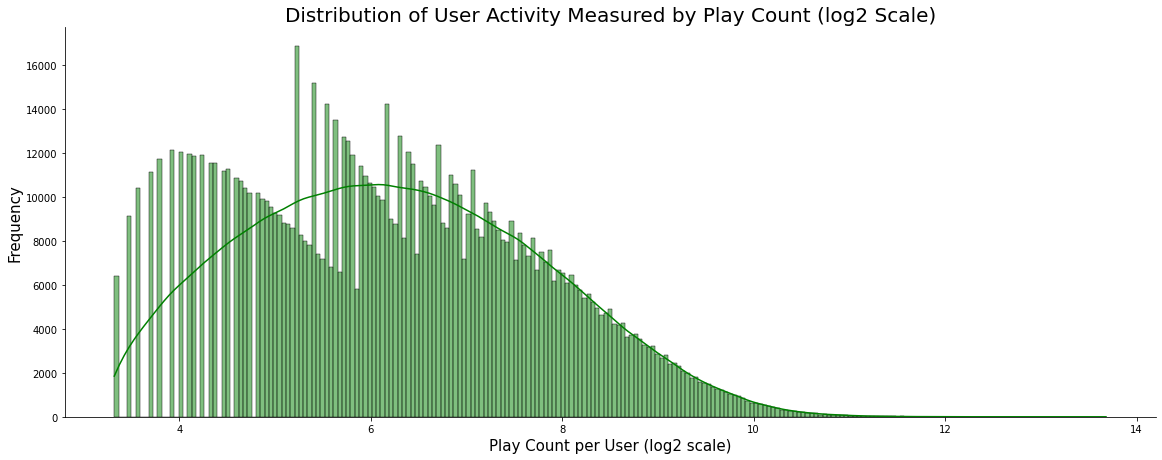

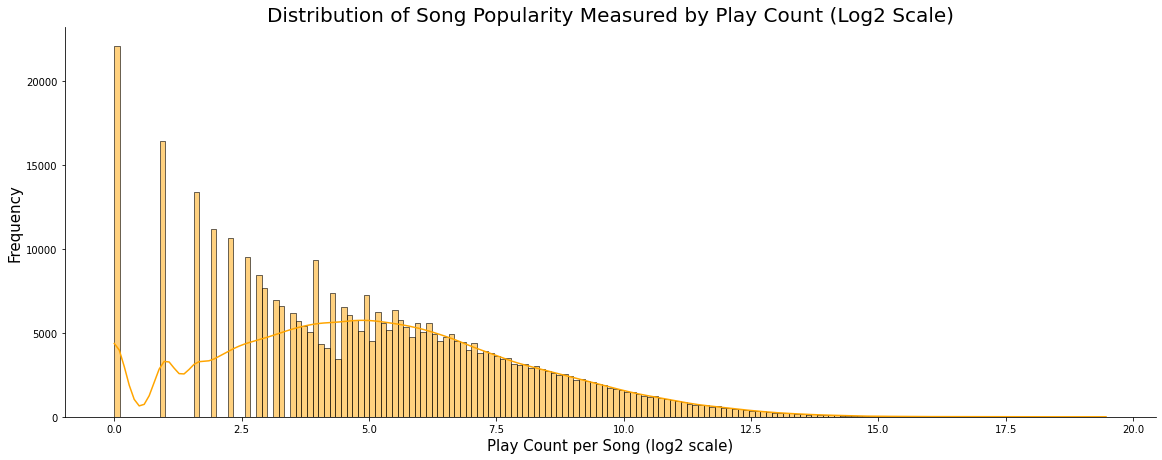

In [18]:
sns.displot(x='log2_scale_user_plays', data=user_activityPD, kde=True, height=6.5, aspect=2.5, color="green")

plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of User Activity Measured by Play Count (log2 Scale)', fontsize=20)
plt.xlabel("Play Count per User (log2 scale)", fontsize=15)
plt.tight_layout()


# i couldnt get the actual distribution of this to plot for some reason 
# so you get it in log 2 and you'll like it because you have no other choice

sns.displot(x='log2_scale_total_plays', data=popularity_distributionPD, kde=True, height=6.5, aspect=2.5, color="orange")

plt.xlabel('Play Count per Song (log2 scale)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Distribution of Song Popularity Measured by Play Count (Log2 Scale)", fontsize=20)
plt.tight_layout()

## Q1d

In [19]:
user_threshold=50 # N
song_threshold=50 # M

threshold_users_plays = (triplets
                         .groupBy("user_id")
                         .agg(F.count("plays").alias("user_total_plays"))
                         .filter(F.col("user_total_plays")>=user_threshold)
                         .join(triplets, on="user_id", how="left"))


threshold_data = (threshold_users_plays
                  .groupBy("song_id")
                  .agg(F.count("plays").alias("song_total_plays"))
                  .filter(F.col("song_total_plays")>=song_threshold)
                  .join(threshold_users_plays, on="song_id", how="left")
                  .drop("user_total_plays", "song_total_plays"))


## Q1e

as a personal note, when you say "the test set should contain at least 25% of the plays in total, 
it would be helpful to specify if you mean 25% of the total plays or of the plays in the "clean" dataset. 
Not all of us are neurotypical and can read the silent implication 
(aka i had to give chatgpt you directions and ask it which one i should use. it said the clean data so if thats wrong dont blame me and be more specific)

In [20]:
# Simple random splitting

training, test_unmatched = threshold_data.randomSplit([0.75, 0.25]) 
training.cache()
test_unmatched.cache()

# show_as_html(test_unmatched)
test=test_unmatched.join(training, on="user_id", how="left_semi")
test.cache()



# show_as_html(training)
# show_as_html(test)

DataFrame[user_id: string, song_id: string, plays: int]

In [21]:
print(f'# training rows = {training.count()}')
print(f'# unmatched test rows     = {test_unmatched.count()}')
print(f'# matched test rows     = {test.count()}')
print(f'test lost {test_unmatched.count()-test.count()} rows in the matching join')
print("")


test_total_percent = (test.select(F.sum(test.plays).alias("test_plays"))
                .withColumn("test_plays", F.col("test_plays").cast("integer"))
                .select((F.col("test_plays") / triplets.select(F.sum(triplets.plays).alias("all_plays")).first()["all_plays"]) * 100)
                .first()[0])

test_threshold_percent = (test.select(F.sum(test.plays).alias("test_plays"))
                .withColumn("test_plays", F.col("test_plays").cast("integer"))
                .select((F.col("test_plays") / threshold_data.select(F.sum(threshold_data.plays).alias("all_plays")).first()["all_plays"]) * 100)
                .first()[0])


                
# print(f'test has {round(test_total_percent,2)}% of all plays')
print(f'test has {round(test_threshold_percent,2)}% of all plays in threshold_data')

# training rows = 21499439
# unmatched test rows     = 7168880
# matched test rows     = 7168880
test lost 0 rows in the matching join

test has 25.02% of all plays in threshold_data


## Q2
### Q2a

In [22]:
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in list(set(training.columns)-set(['plays'])) ]
pipeline = Pipeline(stages=indexer)
transformed_training = pipeline.fit(training).transform(training)
transformed_test = pipeline.fit(test).transform(test)

In [23]:
als = ALS(maxIter=5, regParam=0.01, userCol="user_id_index", itemCol="song_id_index", ratingCol="plays", implicitPrefs=True)
alsModel = als.fit(transformed_training)


pred = alsModel.transform(transformed_test)
pred.cache()

DataFrame[user_id: string, song_id: string, plays: int, user_id_index: double, song_id_index: double, prediction: float]

### Q2b

In [24]:
top_users_inTest = (transformed_test
                    .groupBy("user_id")
                    .agg(F.count("plays").alias("user_total_plays"))
                    .orderBy(F.col("user_total_plays").desc())
                    .limit(15)
                    .select(F.col("user_id"))
                    .join(transformed_test, on="user_id", how="left"))

top_user_ids = (top_users_inTest.select(F.col("user_id_index")).dropDuplicates())

In [28]:
# this was from a Medium article about ALS for recommendations

# evaluator=RegressionEvaluator(metricName="rmse",labelCol="plays",predictionCol="prediction")
# rmse=evaluator.evaluate(pred)
# print("RMSE="+str(rmse)) 
# my notes say you cant use RMSE for implicit data so ignore this


k = 5
recommendations = alsModel.recommendForUserSubset(top_users_inTest, 10)
recommendations.cache()

DataFrame[user_id_index: int, recommendations: array<struct<song_id_index:int,rating:float>>]

In [29]:
# recommendations.show()

In [30]:
relevant = (
    top_users_inTest
    .groupBy("user_id_index")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("plays"),
                F.col("song_id_index")
            )))).alias("relevant")))

temp = (
    recommendations
    .select(
        F.col("user_id_index"),
        F.col("recommendations.song_id_index").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_id_index"),
            F.col("relevant.song_id_index").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_id_index",
        how="inner"))

temp.cache()

# show_as_html(temp)

DataFrame[user_id_index: int, recommendations: array<double>, relevant: array<double>]

In [31]:
common = temp.withColumn("overlap", F.array_intersect(temp.recommendations, temp.relevant))
show_as_html(common)
# common.show(truncate=False)


# i had to rerun this to get my overlap table while writing the report
# so uhhhhh if the values dont match up with other stuff just ignore that ok thanks

,user_id_index,recommendations,relevant,overlap
0,7,"[1.0, 0.0, 14.0, 8.0, 16.0, 24.0, 7.0, 27.0, 1...","[804.0, 3358.0, 2052.0, 3102.0, 3431.0, 2058.0...",[]
1,4,"[24.0, 28.0, 12.0, 0.0, 15.0, 62.0, 139.0, 8.0...","[284.0, 415.0, 6739.0, 10389.0, 6494.0, 1168.0...",[8.0]
2,9,"[1.0, 14.0, 48.0, 47.0, 68.0, 33.0, 3.0, 97.0,...","[4418.0, 5027.0, 121.0, 19.0, 2889.0, 484.0, 6...","[47.0, 11.0]"
3,3,"[14.0, 24.0, 201.0, 28.0, 11.0, 97.0, 41.0, 62...","[31002.0, 4219.0, 2215.0, 9020.0, 338.0, 20915...",[14.0]
4,11,"[16.0, 14.0, 42.0, 33.0, 47.0, 201.0, 217.0, 3...","[16314.0, 6171.0, 50.0, 9377.0, 333.0, 10739.0...",[]
5,12,"[213.0, 42.0, 318.0, 70.0, 286.0, 402.0, 46.0,...","[13853.0, 10579.0, 5486.0, 7442.0, 23975.0, 85...",[]
6,1,"[47.0, 48.0, 1.0, 14.0, 33.0, 97.0, 134.0, 136...","[7425.0, 3740.0, 18317.0, 4199.0, 8682.0, 112....",[11.0]
7,14,"[41.0, 14.0, 28.0, 24.0, 9.0, 32.0, 76.0, 62.0...","[6270.0, 6368.0, 5961.0, 19060.0, 63835.0, 524...",[]
8,0,"[14.0, 201.0, 97.0, 11.0, 163.0, 136.0, 297.0,...","[77699.0, 75994.0, 73323.0, 67826.0, 62652.0, ...",[]
9,2,"[1.0, 48.0, 136.0, 97.0, 47.0, 68.0, 245.0, 35...","[2639.0, 11420.0, 1462.0, 164.0, 32959.0, 836....",[97.0]


+-------------+------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Q2c

In [30]:
# Metrics

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.06667
MAP @ K:       0.04744
NDCG @ K:      0.08588



# Bonus (aka trying to improve my metrics)

### lowering thresholds
I also tried 10 as the threshold for both but that was a struggle so I switched to just lowering the song (cause lowering the user threshold adds a LOT of users when there are over 1M users

I kind of messed around with this same section several times with different thresholds so you wont see all of them in here

In [55]:
# everything except thresholds is the same (50 to 10 song)

user_threshold=75 # N
song_threshold=75 # M

threshold_users_plays = (triplets
                         .groupBy("user_id")
                         .agg(F.count("plays").alias("user_total_plays"))
                         .filter(F.col("user_total_plays")>=user_threshold)
                         .join(triplets, on="user_id", how="left"))


threshold_data = (threshold_users_plays
                  .groupBy("song_id")
                  .agg(F.count("plays").alias("song_total_plays"))
                  .filter(F.col("song_total_plays")>=song_threshold)
                  .join(threshold_users_plays, on="song_id", how="left")
                  .drop("user_total_plays", "song_total_plays"))

In [56]:
training, test_unmatched = threshold_data.randomSplit([0.75, 0.25]) 
training.cache()
test_unmatched.cache()

test=test_unmatched.join(training, on="user_id", how="left_semi")
test.cache()

DataFrame[user_id: string, song_id: string, plays: int]

In [57]:
indexer = [StringIndexer(
    inputCol=column, outputCol=column+"_index") for column in list(set(training.columns)-set(['plays']))]

pipeline = Pipeline(stages=indexer)


transformed_training = pipeline.fit(training).transform(training)
transformed_test = pipeline.fit(test).transform(test)

In [58]:
als = ALS(maxIter=5, regParam=0.01, userCol="user_id_index", 
          itemCol="song_id_index", ratingCol="plays", implicitPrefs=True)

alsModel = als.fit(transformed_training)


pred = alsModel.transform(transformed_test)
pred.cache()

DataFrame[user_id: string, song_id: string, plays: int, user_id_index: double, song_id_index: double, prediction: float]

In [59]:
top_users_inTest = (transformed_test
                    .groupBy("user_id")
                    .agg(F.count("plays").alias("user_total_plays"))
                    .orderBy(F.col("user_total_plays").desc())
                    .limit(15)
                    .select(F.col("user_id"))
                    .join(transformed_test, on="user_id", how="left"))


top_user_ids = (top_users_inTest.select(F.col("user_id_index")).dropDuplicates())

In [60]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="plays",predictionCol="prediction")
rmse=evaluator.evaluate(pred)
print("RMSE="+str(rmse))


k = 5
recommendations = alsModel.recommendForUserSubset(top_users_inTest, 5)
recommendations.cache()

RMSE=7.239513679565096


DataFrame[user_id_index: int, recommendations: array<struct<song_id_index:int,rating:float>>]

In [61]:
# spark is throwing a hissy fit on this lower threshold data so I don't think that's the way to go
# perhaps a more intermediate threshold (like 30 or 35) might be more managable, resource wise

relevant = (
    top_users_inTest
    .groupBy("user_id_index")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("plays"),
                F.col("song_id_index")
            )))).alias("relevant")))

temp = (
    recommendations
    .select(
        F.col("user_id_index"),
        F.col("recommendations.song_id_index").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_id_index"),
            F.col("relevant.song_id_index").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_id_index",
        how="inner"))

temp.cache()

# i have so many regrets on this threshold but i'm already in this deep. hindsight and all that

common = temp.withColumn("overlap", F.array_intersect(temp.recommendations, temp.relevant))
show_as_html(common)

,user_id_index,recommendations,relevant,overlap
0,7,"[15.0, 46.0, 35.0, 11.0, 44.0]","[2321.0, 111.0, 87.0, 54.0, 53565.0, 20.0, 175...","[46.0, 44.0]"
1,4,"[14.0, 13.0, 68.0, 41.0, 215.0]","[3459.0, 421.0, 55.0, 4695.0, 5064.0, 30601.0,...",[]
2,9,"[1.0, 3.0, 10.0, 4.0, 13.0]","[21653.0, 4649.0, 17188.0, 33811.0, 17264.0, 2...",[]
3,3,"[91.0, 45.0, 300.0, 218.0, 246.0]","[276.0, 66.0, 235.0, 135.0, 40955.0, 26356.0, ...","[91.0, 246.0]"
4,11,"[15.0, 91.0, 0.0, 99.0, 44.0]","[1604.0, 3445.0, 4274.0, 5167.0, 1035.0, 25762...",[]
5,12,"[210.0, 191.0, 188.0, 15.0, 14.0]","[12139.0, 19337.0, 12.0, 14302.0, 8779.0, 6997...",[]
6,1,"[15.0, 44.0, 45.0, 0.0, 91.0]","[9357.0, 14460.0, 14670.0, 13295.0, 13044.0, 6...",[]
7,14,"[242.0, 294.0, 328.0, 12.0, 117.0]","[7567.0, 4974.0, 7777.0, 27999.0, 9540.0, 4221...",[]
8,0,"[210.0, 11.0, 143.0, 15.0, 242.0]","[49865.0, 48073.0, 45615.0, 44567.0, 40450.0, ...",[242.0]
9,2,"[191.0, 188.0, 71.0, 224.0, 244.0]","[1248.0, 32866.0, 763.0, 718.0, 2895.0, 20921....",[]


In [62]:
# Metrics

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.05333
MAP @ K:       0.02889
NDCG @ K:      0.07223



### Same threshold, increased parameters
this is the extent of my paitence for trying out other things

In [63]:
# increased iterations (5 to 10), regularization increased (0.01 to 0.05) in ALS

user_threshold=50 # N
song_threshold=50 # M

threshold_users_plays = (triplets
                         .groupBy("user_id")
                         .agg(F.count("plays").alias("user_total_plays"))
                         .filter(F.col("user_total_plays")>=user_threshold)
                         .join(triplets, on="user_id", how="left"))


threshold_data = (threshold_users_plays
                  .groupBy("song_id")
                  .agg(F.count("plays").alias("song_total_plays"))
                  .filter(F.col("song_total_plays")>=song_threshold)
                  .join(threshold_users_plays, on="song_id", how="left")
                  .drop("user_total_plays", "song_total_plays"))



In [64]:
training, test_unmatched = threshold_data.randomSplit([0.75, 0.25]) 
training.cache()
test_unmatched.cache()

test=test_unmatched.join(training, on="user_id", how="left_semi")
test.cache()

DataFrame[user_id: string, song_id: string, plays: int]

In [65]:
indexer = [StringIndexer(
    inputCol=column, outputCol=column+"_index") for column in list(set(training.columns)-set(['plays']))]

pipeline = Pipeline(stages=indexer)


transformed_training = pipeline.fit(training).transform(training)
transformed_test = pipeline.fit(test).transform(test)

In [66]:
top_users_inTest = (transformed_test
                    .groupBy("user_id")
                    .agg(F.count("plays").alias("user_total_plays"))
                    .orderBy(F.col("user_total_plays").desc())
                    .limit(15)
                    .select(F.col("user_id"))
                    .join(transformed_test, on="user_id", how="left"))


top_user_ids = (top_users_inTest.select(F.col("user_id_index")).dropDuplicates())

In [68]:
als = ALS(maxIter=15, regParam=0.05, userCol="user_id_index", 
          itemCol="song_id_index", ratingCol="plays", implicitPrefs=True) # thanks chatgpt (again)

alsModel = als.fit(transformed_training)

pred = alsModel.transform(transformed_test)
pred.cache()

DataFrame[user_id: string, song_id: string, plays: int, user_id_index: double, song_id_index: double, prediction: float]

In [69]:
k = 5
recommendations = alsModel.recommendForUserSubset(top_users_inTest, 10)
recommendations.cache()

DataFrame[user_id_index: int, recommendations: array<struct<song_id_index:int,rating:float>>]

In [70]:
relevant = (
    top_users_inTest
    .groupBy("user_id_index")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("plays"),
                F.col("song_id_index")
            )))).alias("relevant")))

temp = (
    recommendations
    .select(
        F.col("user_id_index"),
        F.col("recommendations.song_id_index").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_id_index"),
            F.col("relevant.song_id_index").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_id_index",
        how="inner"))

temp.cache()


common = temp.withColumn("overlap", F.array_intersect(temp.recommendations, temp.relevant))
show_as_html(common)

,user_id_index,recommendations,relevant,overlap
0,7,"[212.0, 393.0, 324.0, 136.0, 42.0, 311.0, 293....","[2683.0, 2.0, 18998.0, 16.0, 3.0, 44372.0, 402...",[212.0]
1,4,"[24.0, 1.0, 22.0, 23.0, 12.0, 15.0, 29.0, 62.0...","[577.0, 5019.0, 1395.0, 1161.0, 22071.0, 1084....","[24.0, 23.0]"
2,9,"[14.0, 0.0, 3.0, 45.0, 5.0, 33.0, 10.0, 67.0, ...","[27207.0, 35332.0, 5209.0, 11315.0, 908.0, 63....",[]
3,3,"[14.0, 203.0, 45.0, 98.0, 0.0, 353.0, 315.0, 1...","[3356.0, 14240.0, 20550.0, 12934.0, 51045.0, 4...",[]
4,11,"[122.0, 3.0, 206.0, 185.0, 1.0, 342.0, 221.0, ...","[73640.0, 38562.0, 13886.0, 59866.0, 23884.0, ...",[]
5,12,"[212.0, 311.0, 393.0, 293.0, 2526.0, 68.0, 111...","[2003.0, 2784.0, 11538.0, 6075.0, 16167.0, 776...",[68.0]
6,1,"[14.0, 45.0, 203.0, 0.0, 98.0, 48.0, 100.0, 33...","[1450.0, 7617.0, 14399.0, 2045.0, 1067.0, 5590...","[14.0, 45.0]"
7,14,"[52.0, 86.0, 191.0, 67.0, 138.0, 229.0, 227.0,...","[1639.0, 10030.0, 9072.0, 5191.0, 1387.0, 5592...",[67.0]
8,0,"[138.0, 347.0, 67.0, 151.0, 212.0, 14.0, 248.0...","[65570.0, 60719.0, 50527.0, 45821.0, 41309.0, ...",[]
9,2,"[16.0, 66.0, 324.0, 210.0, 136.0, 29.0, 24.0, ...","[8128.0, 3318.0, 1608.0, 19.0, 3313.0, 643.0, ...",[16.0]


In [71]:
# Metrics

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.10667
MAP @ K:       0.05563
NDCG @ K:      0.12876



like i dont even think i can subset the data more than just the threshold because the relationships are what's important and you lose the relationships if you subset so i dont know how to be more efficent in just ~testing out~ parameters *god im hungry*

In [72]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()

### a very angry cross validation attempt
and apparently this can give the best parameters to tune. dont ask me to elaborate
##### if you go through this section you will get to see my slow but inevital descend into madness in text form

In [ ]:
# threshold is the same, parameters and....stuff are messed with with cross validator

user_threshold=50 # N
song_threshold=50 # M

threshold_users_plays = (triplets
                         .groupBy("user_id")
                         .agg(F.count("plays").alias("user_total_plays"))
                         .filter(F.col("user_total_plays")>=user_threshold)
                         .join(triplets, on="user_id", how="left"))


threshold_data = (threshold_users_plays
                  .groupBy("song_id")
                  .agg(F.count("plays").alias("song_total_plays"))
                  .filter(F.col("song_total_plays")>=song_threshold)
                  .join(threshold_users_plays, on="song_id", how="left")
                  .drop("user_total_plays", "song_total_plays"))



In [ ]:
training, test_unmatched = threshold_data.randomSplit([0.75, 0.25]) 
training.cache()
test_unmatched.cache()

test=test_unmatched.join(training, on="user_id", how="left_semi")
test.cache()

In [ ]:
indexer = [StringIndexer(
    inputCol=column, outputCol=column+"_index") for column in list(set(training.columns)-set(['plays']))]

pipeline = Pipeline(stages=indexer)


transformed_training = pipeline.fit(training).transform(training)
transformed_test = pipeline.fit(test).transform(test)

In [ ]:
top_users_inTest = (transformed_test
                    .groupBy("user_id")
                    .agg(F.count("plays").alias("user_total_plays"))
                    .orderBy(F.col("user_total_plays").desc())
                    .limit(15)
                    .select(F.col("user_id"))
                    .join(transformed_test, on="user_id", how="left"))


top_user_ids = (top_users_inTest.select(F.col("user_id_index")).dropDuplicates())

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [ ]:
# initialize the ALS model
als_model = ALS(userCol='user_id_index', itemCol='song_id_index', ratingCol='plays', implicitPrefs=True)

# create the parameter grid
params = ParamGridBuilder().addGrid(als_model.regParam, [.01, .05, .1, .15]).addGrid(als_model.rank, [10, 50, 100, 150]).build()

#instantiating crossvalidator estimator

cv = CrossValidator(estimator=als_model, estimatorParamMaps=params, evaluator=evaluator, parallelism=4)

best_model = cv.fit(movie_ratings)

model = best_model.bestModel



# Create ALS estimator
als = ALS(userCol="user_id_index", itemCol="song_id_index", ratingCol="plays", implicitPrefs=True)

# Define the evaluator
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="plays", metricName="rmse")


# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.regParam, [0.01, 0.05, 0.1]) \
    .build()

# Create ALS model and fit it on the training data
alsModel = als.fit(transformed_training)

# Create TrainValidationSplit
tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

I know i shouldnt be ADMITING that i have no idea what im doing but 

In [ ]:
# Run train validation split
tvsModel = tvs.fit(transformed_training)

In [ ]:
# Get the best model from the train validation split
bestModel = tvsModel.bestModel

In [ ]:
als = ALS(userCol="user_id_index", itemCol="song_id_index", ratingCol="plays", implicitPrefs=True)

alsModel = als.fit(transformed_training)

pred = alsModel.transform(transformed_test)
pred.cache()

# Define the evaluator
evaluator = RankingEvaluator(predictionCol="prediction", labelCol="plays", metricName="ndcgAtK")


In [ ]:

# Define the parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.regParam, [0.01, 0.05, 0.1]) \
    .build()

# Create cross-validator
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
# Run cross-validation
cvModel = crossval.fit(transformed_training)

In [ ]:
evaluator = RegressionEvaluator(metricName='ndcgAtK', labelCol='plays', predictionCol='prediction')

als_model = ALS(userCol='user_id_index', itemCol='song_id_index', ratingCol='plays', implicitPrefs=True)

params = ParamGridBuilder().addGrid(als_model.regParam, [.01, .05, .1, .15]).addGrid(als_model.rank, [10, 50, 100, 150]).build()

cv = CrossValidator(estimator=als_model, estimatorParamMaps=params, evaluator=evaluator, parallelism=4)

In [ ]:
best_model = cv.fit(transformed_training)

i fucking quit. i dont care about cross validation it can shove it

In [ ]:
# this is (almost) completely from chatgpt and yes i know i probably should know how to do it myself but i simply dont
# chatgpt was definitely wrong/missing some things so i fixed/filled in with the excersise 4 example


# evaluator = RankingEvaluator(
#     predictionCol="prediction",
#     labelCol="plays",
#     metricName="ndcgAtK",
#     k=10)


# als = ALS(maxIter=5, regParam=0.01, userCol="user_id_index", 
#           itemCol="song_id_index", ratingCol="plays", implicitPrefs=True)

# model=als.fit(transformed_training)
# predictions = model.transform(transformed_test)

# evaluator = RegressionEvaluator(metricName='ndcgAtK', labelCol='plays', predictionCol='prediction')

# als_model = ALS(userCol='user_id_index', itemCol='song_id_index', ratingCol='plays', implicitPrefs=True)

# params = ParamGridBuilder().addGrid(als_model.regParam, [.01, .05, .1, .15]).addGrid(als_model.rank, [10, 50, 100, 150]).build()

# cv = CrossValidator(estimator=als_model, estimatorParamMaps=params, evaluator=evaluator, parallelism=4)

best_model = cv.fit(transformed_training)

model = best_model.bestModel

predictions = model.transform(transformed_test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)


# # Define the parameter grid
# paramGrid = ParamGridBuilder() \
#     .addGrid(als.rank, [10, 20, 30]) \
#     .addGrid(als.regParam, [0.01, 0.05, 0.1]) \
#     .build()


# cv = CrossValidator(estimator=als, \
#                     estimatorParamMaps=paramGrid, \
#                     evaluator=evaluator, \
#                     numFolds=5)

# cvModel = cv.fit(transformed_training)

# predictions = cvModel.transform(transformed_test)


# # Create cross-validator
# crossval = CrossValidator(estimator=als,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=evaluator,
#                           numFolds=3)

# # Run cross-validation
# cvModel = crossval.fit(transformed_test)

# Get the best model
bestModel = cvModel.bestModel

# Make predictions using the best model
pred = bestModel.transform(transformed_test)
pred.cache()

# Evaluate the predictions
rmse = evaluator.evaluate(pred)
print("RMSE =", rmse)

# Get the best model's parameters
bestRank = bestModel.rank
bestRegParam = bestModel.regParam

print("Best Model:")
print("Rank =", bestRank)
print("RegParam =", bestRegParam)
# wake me up when this is done running. or when september ends. whichever comes first

In [ ]:
# back to our regularly scheduled programming (he-he programming, which this technically isnt but still seems funny to me)

k = 5
recommendations = bestModel.recommendForUserSubset(top_users_inTest, 5)
recommendations.cache()

In [ ]:
relevant = (
    top_users_inTest
    .groupBy("user_id_index")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("plays"),
                F.col("song_id_index")
            )))).alias("relevant")))

temp = (
    recommendations
    .select(
        F.col("user_id_index"),
        F.col("recommendations.song_id_index").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user_id_index"),
            F.col("relevant.song_id_index").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user_id_index",
        how="inner"))

temp.cache()


common = temp.withColumn("overlap", F.array_intersect(temp.recommendations, temp.relevant))
common.show()

In [ ]:
# Metrics

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')
# yes you are witnessing my slow but inevital descend into madness in text form